# Face Recognition

In [626]:
import pandas as pd
import base64
import numpy as np
from PIL import Image
import io
import cv2 as cv2
from io import BytesIO
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import random as rand
from scipy import io as sp
import dlib
import os
import itertools as it
import pixiedust
from sklearn.metrics import accuracy_score
import tensorflow as tf 
from sklearn.manifold import TSNE
colors = sns.color_palette()
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, MaxPool2D, Activation, Flatten, Dense, Dropout
from keras.layers import concatenate


# MAC OS specific setting
os.environ['KMP_DUPLICATE_LIB_OK']='True'

### Load celebrity name data
The dataset is downloaded from the MS-Celeb-1M provide by Microsoft
__["MS-Celeb-1M: A Dataset and Benchmark for Large Scale Face Recognition"](https://www.msceleb.org/download/devset)__

In [627]:
celebName = pd.read_csv('Top1M_MidList.Name.tsv',names=['Id','Name'], delimiter='\t', error_bad_lines=False)
language = celebName['Name'].str.split("@", n=1, expand=True)
celebName['Name'] = language[0]
celebName['Language'] = language[1]
celebName = celebName[celebName['Language'] == 'en']
celebName.drop(columns=['Language'], inplace=True)

### Load celebrity images

In [628]:
clebs = pd.read_csv('images.tsv', delimiter="\t", engine='python', error_bad_lines=False)

### Join on id

In [629]:
clebs = clebs.merge(celebName, how='left', left_on='Id', right_on='Id')
del celebName

### Sample Data

In [630]:
clebs.head()

,Id,Image,Name
0,m.0169dl,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAQCAwMDAgQDAw...,Matt Damon
1,m.0169dl,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAQCAwMDAgQDAw...,Matt Damon
2,m.0169dl,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAQCAwMDAgQDAw...,Matt Damon
3,m.0169dl,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAQCAwMDAgQDAw...,Matt Damon
4,m.0169dl,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAQCAwMDAgQDAw...,Matt Damon


### Data distribution

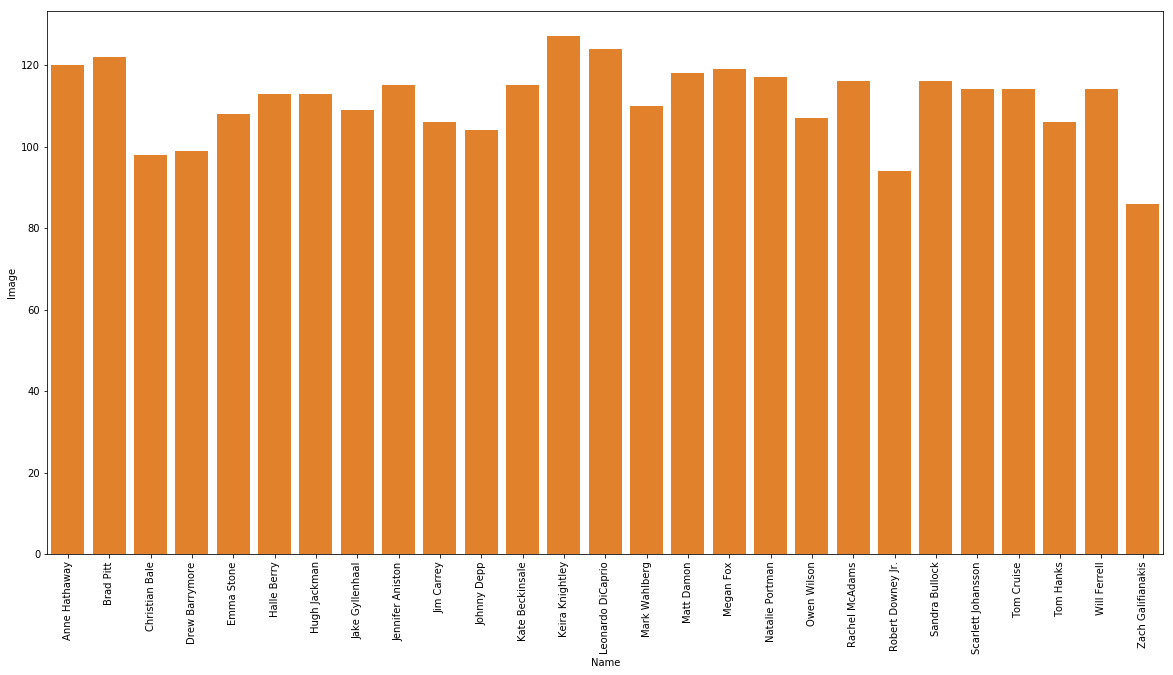

In [631]:
celebCount = clebs.groupby(['Name']).count().reset_index()
plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
sns.barplot(x='Name', y='Image', data=celebCount, color = colors[1])
plt.show()

### Utility functions to work around with Images

In [632]:
def get_image(base64Image, display=True):
    img = Image.open(BytesIO(base64.b64decode(base64Image))).convert('RGB') 
    if display:
        plt.figure(figsize=(8,8))
        plt.imshow(img)
    return img
#   to open image in new window
#   img.show()

def get_opencv2_image(base64Image, display=False):
    return cv2.cvtColor(np.array(get_image(base64Image, display)), cv2.COLOR_RGB2BGR)

def convertToRGB(opencv2_image):
    return cv2.cvtColor(opencv2_image, cv2.COLOR_BGR2RGB)

def rect_to_cordinate(rect):
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y
    return (x, y, w, h)

def shape_to_np(shape, dtype="int"):
    # initialize the list of (x, y)-coordinates
    coords = np.zeros((68, 2), dtype=dtype)
 
    # loop over the 68 facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    for i in range(0, 68):
        coords[i] = (shape.part(i).x, shape.part(i).y)
 
    # return the list of (x, y)-coordinates
    return coords

### Detect Faces in a image using the dlib frontal face detector

In [633]:
def detect_faces(test_image, display=True, scaleFactor = 1):
    face_detector = dlib.get_frontal_face_detector()
    faces_rect = face_detector(test_image, 1)
    
    if display:
        image_copy = test_image.copy()
        for rect in faces_rect:
            (x,y,w,h) = rect_to_cordinate(rect)
            cv2.rectangle(image_copy, (x,y), (x+w, y+h), (0,255,255), 2)
    
    if display:
        plt.figure(figsize=(8,8))
        plt.imshow(convertToRGB(image_copy))
    
    return faces_rect

### Detect Landmarks on face using the dlib shape predictor

In [634]:
def detect_landmarks(image, faces, display=True):
    pose_landmarks = None
    face_pose_predictor = dlib.shape_predictor("./shape_predictor_68_face_landmarks.dat")
    
    if display:
        test_copy = image.copy()
    
    for face in faces:
        pose_landmarks = face_pose_predictor(image, face)
        if display:
            for (x, y) in shape_to_np(pose_landmarks):
                cv2.circle(test_copy, (x, y), 1, (0,0,255), -1)
    if display:
        plt.figure(figsize=(8,8))
        plt.imshow(convertToRGB(test_copy))
    
    return pose_landmarks

### Scale the image to 128x128 and fix posture 

In [702]:
def scale_face(image, landmarks, display=True):
    fod = dlib.full_object_detections()
    fod.append(landmarks)
    img = dlib.get_face_chips(image, fod, size=)
    if display:
        for x in img:
            plt.figure(figsize=(8,8))
            plt.imshow(convertToRGB(x))
    return img

### Utililty function to get scaled postured image of 128x128 using the above functions

In [703]:
from skimage.color import rgb2gray
def get_scaled(base64image,display=False):
    img_raw = get_opencv2_image(base64image)
    faces = detect_faces(img_raw,display=False)
    if not faces:
        return np.nan
    landmarks = detect_landmarks(img_raw, faces,display=False)
    scaleimg = scale_face(img_raw, landmarks, display=display)
    return scaleimg[0]
def get_greyscale(image_numpy):
    return rgb2gray(image_numpy)

### Detect Faces

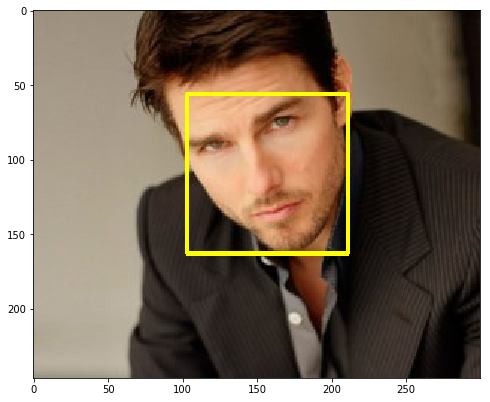

In [705]:
i = rand.randrange(0,len(clebs))
base64image = clebs.iloc[i]['Image']
img_raw = get_opencv2_image(base64image)
faces = detect_faces(img_raw)

## Dectect landmarks

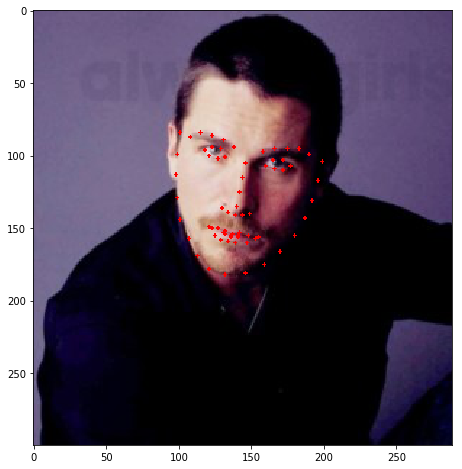

In [417]:
landmarks = detect_landmarks(img_raw, faces)

# Scale And Align Images

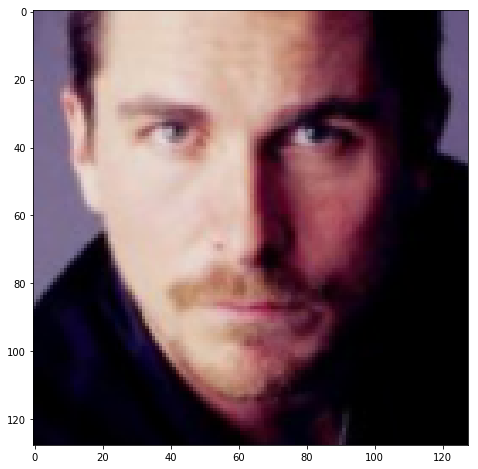

In [418]:
scaleimg = scale_face(img_raw, landmarks, display=True)

In [420]:
# # Save a subset of dataset with scaled images
# n = len(clebs)
# for i in range(n):
#     print('Progess [{}/{}]'.format(i,n))
#     if rand.randint(0,10) > 0:
#         clebs.iloc[i]['Image'] = get_scaled(clebs.iloc[i]['Image'], display=False)
#     else:
#         clebs.iloc[i]['Image'] = np.nan
# clebs.dropna(inplace=True)
# np.save('scaled_subset', clebs.values)

### Create Pairs
Create x_positive pair (x,y) where x and y are the images of the same celebrity <br>
Create x_negative pair (x,y) where x and y are the images of different celebrity <br>
Label the cost for positive pairs as 0 <br>
Label the cost for negative pairs as 1


In [422]:
dataset = np.load('scaled_subset.npy')
labels = np.unique(dataset.T[:][0])
x_positive = []
x_negative = []

positive_sample_size = 1
negative_sample_size = 0.0004

for l in labels:
    combos_positive = list(it.combinations(dataset[np.where(dataset.T[:][0] == l)].T[1], 2))
    index = np.arange(len(combos_positive))
    np.random.shuffle(index)
    index = index[: int(len(combos_positive)*positive_sample_size)]
    x_positive += [combos_positive[j] for j in index]
    
    combos_negative = list(it.combinations(dataset[np.where(dataset.T[:][0] != l)].T[1], 2))
    index = np.arange(len(combos_negative))
    np.random.shuffle(index)
    index = index[: int(len(combos_negative)*negative_sample_size)]
    x_negative += [combos_negative[j] for j in index]


print('Positive Pairs {}'.format(len(x_positive)))
print('Negative Pairs {}'.format(len(x_negative)))
X = np.vstack((np.asarray(x_positive), np.asarray(x_negative)))
y = np.vstack((np.full((len(x_positive),1),0), np.full((len(x_negative),1),1)))
print(X.shape)
print(y.shape)
np.save('Dataset', X)
np.save('Labels', y)

Positive Pairs 21145
Negative Pairs 5670
(26815, 2, 128, 128, 3)
(26815, 1)


In [493]:
X = np.load('Dataset.npy')
y = np.load('Labels.npy')

### Sample of negative pairs

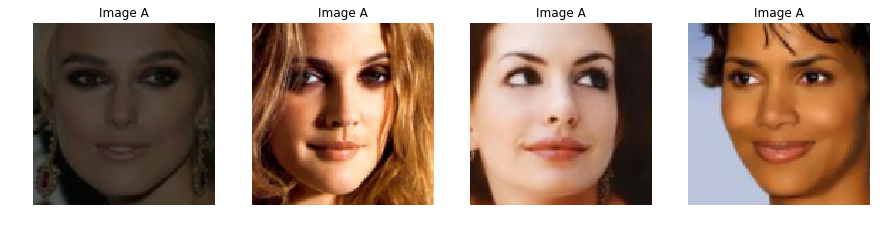

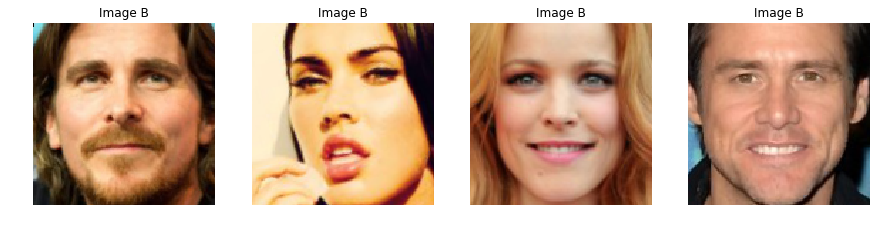

In [424]:
Xs = X[np.random.choice(np.where(y[:]==1)[0],4)]
fig, axarr = plt.subplots(1,4,figsize=(15,15))
plt.axis('off')
for i in range(4):
    axarr[i].imshow(convertToRGB(Xs[i][0]))
    axarr[i].axis('off')
    axarr[i].set_title('Image A')
    
fig, axarr = plt.subplots(1,4,figsize=(15,15))
plt.axis('off')
for i in range(4):
    axarr[i].imshow(convertToRGB(Xs[i][1]))
    axarr[i].axis('off')
    axarr[i].set_title('Image B')

### Sample of Positive pair

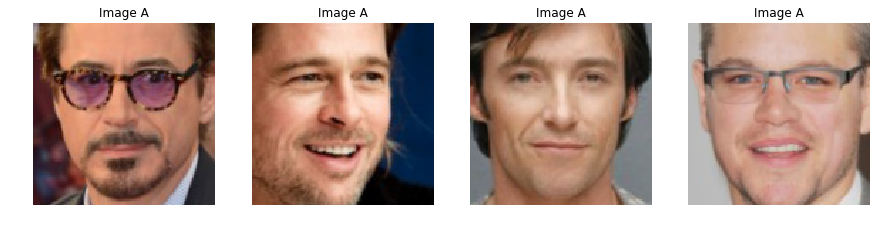

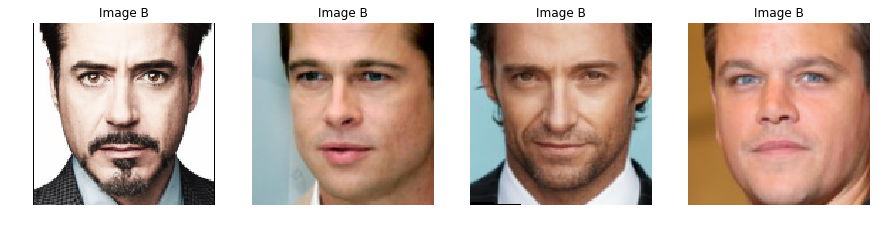

In [425]:
Xs = X[np.random.choice(np.where(y[:]==0)[0],4)]
fig, axarr = plt.subplots(1,4,figsize=(15,15))
plt.axis('off')
for i in range(4):
    axarr[i].imshow(convertToRGB(Xs[i][0]))
    axarr[i].axis('off')
    axarr[i].set_title('Image A')
    
fig, axarr = plt.subplots(1,4,figsize=(15,15))
plt.axis('off')
for i in range(4):
    axarr[i].imshow(convertToRGB(Xs[i][1]))
    axarr[i].axis('off')
    axarr[i].set_title('Image B')

In [426]:
image_dimension = [128,128,3]
input_dim = image_dimension
img_a = Input(shape=input_dim)
img_b = Input(shape=input_dim)

### Siamese neural network
For our model we will be using a siamese neural network where for the positive pair we will try to minimize the cost and for the negative model we will try to maximize the cost <br>
To do so we first create a CNN network to extract the 32 feature points of a point. The goal is to train this CNN such for the same celebrity the 32 feature points are similar. Only trained we use any normal vector comparision function to find the closest match. In our case we use the Eculedian distance

In [489]:
img_in = Input(shape = image_dimension, name = 'FeatureNet_ImageInput')
n_layer = img_in
for i in range(2):
    n_layer = Conv2D(8*2**i, kernel_size = 3, activation = 'linear')(n_layer)
    n_layer = BatchNormalization()(n_layer)
    n_layer = Activation('relu')(n_layer)
    n_layer = Conv2D(16*2**i, kernel_size = 3, activation = 'linear')(n_layer)
    n_layer = BatchNormalization()(n_layer)
    n_layer = Activation('relu')(n_layer)
    n_layer = MaxPool2D((2,2))(n_layer)
n_layer = Flatten()(n_layer)
n_layer = Dense(32, activation = 'linear')(n_layer)
n_layer = Dropout(0.3)(n_layer)
n_layer = BatchNormalization()(n_layer)
n_layer = Activation('relu')(n_layer)
feature_model = Model(inputs = [img_in], outputs = [n_layer], name = 'FeatureGenerationModel')
feature_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
FeatureNet_ImageInput (Input (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 126, 126, 8)       224       
_________________________________________________________________
batch_normalization_27 (Batc (None, 126, 126, 8)       32        
_________________________________________________________________
activation_27 (Activation)   (None, 126, 126, 8)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 124, 124, 16)      1168      
_________________________________________________________________
batch_normalization_28 (Batc (None, 124, 124, 16)      64        
_________________________________________________________________
activation_28 (Activation)   (None, 124, 124, 16)      0         
__________

In [490]:
img_a_in = Input(shape = image_dimension, name = 'ImageA_Input')
img_b_in = Input(shape = image_dimension, name = 'ImageB_Input')
img_a_feat = feature_model(img_a_in)
img_b_feat = feature_model(img_b_in)
combined_features = concatenate([img_a_feat, img_b_feat], name = 'merge_features')
combined_features = Dense(16, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(4, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(1, activation = 'sigmoid')(combined_features)
similarity_model = Model(inputs = [img_a_in, img_b_in], outputs = [combined_features], name = 'Similarity_Model')
similarity_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ImageA_Input (InputLayer)       (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
ImageB_Input (InputLayer)       (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
FeatureGenerationModel (Model)  (None, 32)           869984      ImageA_Input[0][0]               
                                                                 ImageB_Input[0][0]               
__________________________________________________________________________________________________
merge_features (Concatenate)    (None, 64)           0           FeatureGenerationModel[1][0]     
          

In [491]:
similarity_model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['mae'])

### Split the dataset train and test 

In [494]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
print('Train Shape {}'.format(X_train.shape))
print('Test Shape {}'.format(X_test.shape))
pairs = [X_train[:,0,:,:,:], X_train[:,1,:,:,:]]

Train Shape (18770, 2, 128, 128, 3)
Test Shape (8045, 2, 128, 128, 3)


In [495]:
# similarity_model.fit(pairs, y_train, epochs=10, verbose=2)
# similarity_model.save_weights("similarity_model.h5")
# feature_model.save_weights("feature_model.h5")

In [496]:
similarity_model.load_weights('similarity_model.h5')
feature_model.load_weights('feature_model.h5')

In [497]:
pairs_test = [X_test[:,0,:,:,:], X_test[:,1,:,:,:]]
predicted = similarity_model.predict(pairs_test, verbose=2)
print('Accuracy')
accuracy_score(y_test, np.around(predicted).astype('int'))

Accuracy


0.9414543194530764

### Prediction on some points

/anaconda3/lib/python3.7/site-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


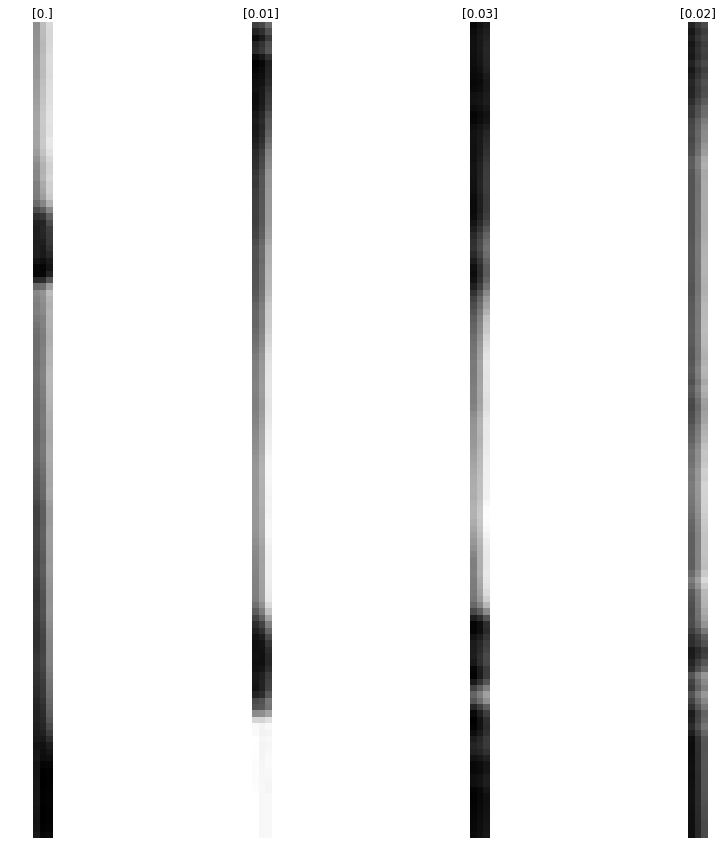

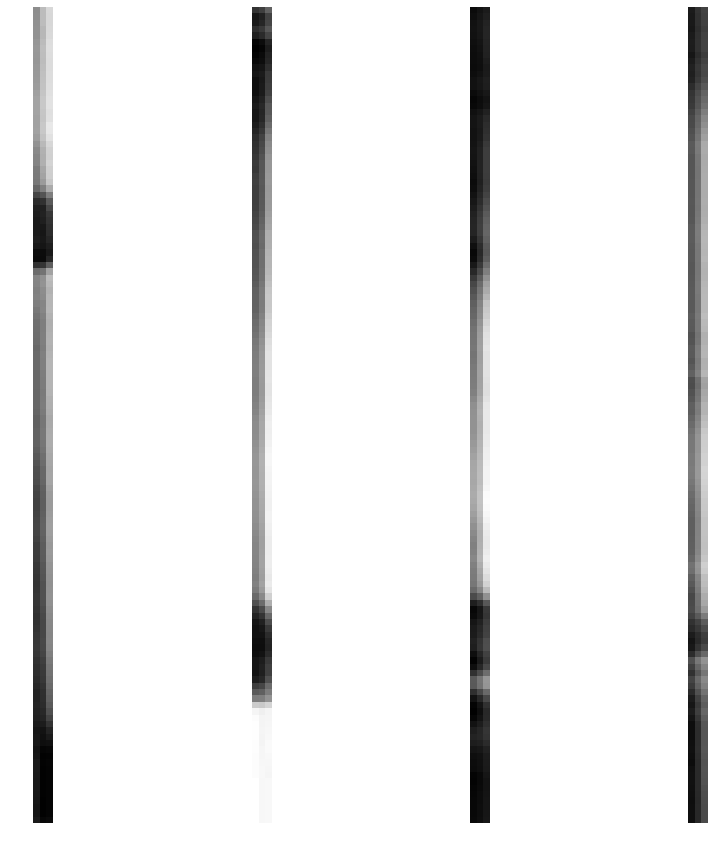

In [617]:
index = np.random.choice(np.arange(len(y_test)),4)
Xs = X_test[index]
Y = predicted[index]
fig, axarr = plt.subplots(1,4,figsize=(15,15))
plt.axis('off')
for i in range(4):
    axarr[i].imshow(convertToRGB(Xs[i][0]))
    axarr[i].axis('off')
    axarr[i].set_title(Y[i])
    
fig, axarr = plt.subplots(1,4,figsize=(15,15))
plt.axis('off')
for i in range(4):
    axarr[i].imshow(convertToRGB(Xs[i][1]))
    axarr[i].axis('off')

In [618]:
dataset = np.load('scaled.npy')
images = np.asarray([dataset[i][1] for i in range(len(dataset))])
labels = np.asarray([dataset[i][2] for i in range(len(dataset))])
unique_labels = np.unique(labels)
images_feature = feature_model.predict(images, verbose = True)

2371/2371 [==============================] - 14s 6ms/step


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2371 samples in 0.011s...
[t-SNE] Computed neighbors for 2371 samples in 0.299s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2371
[t-SNE] Computed conditional probabilities for sample 2000 / 2371
[t-SNE] Computed conditional probabilities for sample 2371 / 2371
[t-SNE] Mean sigma: 0.227471
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.514458
[t-SNE] KL divergence after 1000 iterations: 0.958554


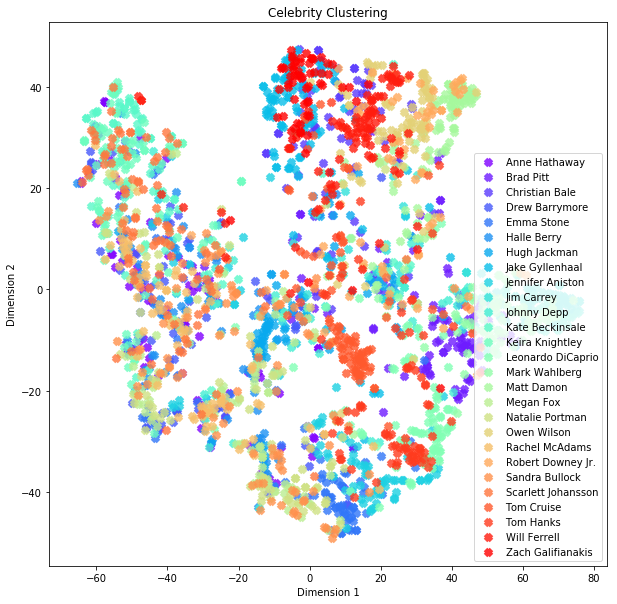

In [619]:
tsne = TSNE(n_components=2, init='pca', n_iter=1000, verbose=1)
tsne_features = tsne.fit_transform(images_feature)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
plt.figure(figsize=(10, 10))
for _, (c_color, name) in enumerate(zip(colors, unique_labels)):
    plt.scatter(tsne_features[np.where(labels == name), 0],
                tsne_features[np.where(labels == name), 1],
                marker='x',
                color=c_color,
                linewidth='5',
                alpha=0.8,
                label=name)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend(loc='best')
plt.title('Celebrity Clustering')
plt.savefig('clusterColor.png')
plt.show()

In [620]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2)
X_features = feature_model.predict(X_train, verbose = True)
Xt_features = feature_model.predict(X_test, verbose = True)
groups = [X_features[np.where(y_train==i)[0]] for i in unique_labels]
groupImage = [X_train[np.where(y_train==i)[0]] for i in unique_labels]

475/475 [==============================] - 2s 5ms/step


In [621]:
y_predict = [np.argmin(np.mean((X_features - i)**2, axis=1)) for i in Xt_features]
y_predict = y_train[y_predict]

In [622]:
from sklearn.metrics import precision_score
accuracy_score(y_test, y_predict)

0.4126315789473684

Confusion matrix, without normalization


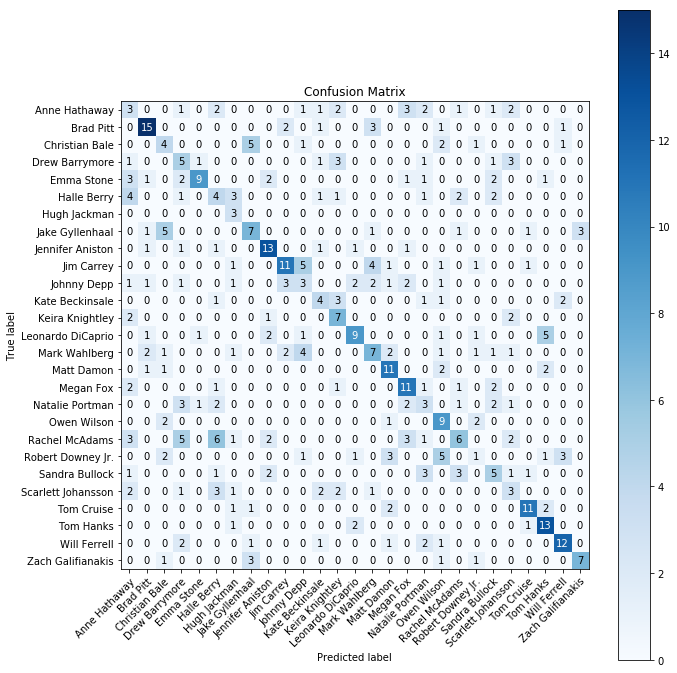

In [624]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_predict, unique_labels, title='Confusion Matrix')
plt.savefig('ConfusionMatrixColor.png')
plt.show()